# Face Classification using a Pre-trained VGGFace Network

# Importing Libraries

In this section the needed libraries are imported.

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, random_split, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm

In [2]:
!nvidia-smi

Fri Dec  1 15:01:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:2B:00.0 Off |                    0 |
| N/A   47C    P0              51W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Data Loading and Preparation

In this First section, we will load and prepare the data for training. First, we initialize the directories that will be used.

In [3]:
data_dir = 'Data'
train_data_dir = os.path.join(data_dir, 'db_train.raw')
train_labels_dir = os.path.join(data_dir, 'label_train.txt')
test_data_dir = os.path.join(data_dir, 'db_test.raw')

Then, we define other image-related variables, as well as the size of the training data, which determines the shape of our imported data. Next, we read the images from the file and reshape them to the desired shape. We also import the training labels and format them into an array, similar to the training images.

In [4]:
width = 56
height = 56
n_channels = 3
n_images_train = 111430

#change later, implement directly
shape_train = (n_images_train, height, width, n_channels)

with open(train_data_dir, 'rb') as file:
    raw_train_data = file.read()

train_data = np.frombuffer(raw_train_data, dtype=np.uint8).reshape(shape_train)
train_data = np.transpose(train_data, (0,1,2,3))

with open(train_labels_dir, 'r') as file:
    train_labels = [int(line.strip()) for line in file]

train_labels = np.array(train_labels)

print(f'Training data shape: {train_data.shape} between {np.min(train_data)} and {np.max(train_data)}.')
print(f'Training labels shape: {train_labels.shape}, divided such that {sum(train_labels == 0)} images are of class 0 and {sum(train_labels == 1)} images are of class 1.')

Training data shape: (111430, 56, 56, 3) between 0 and 255.
Training labels shape: (111430,), divided such that 15250 images are of class 0 and 96180 images are of class 1.


The training data is now represented by a numpy array with the shape (111430, 56, 56, 3), where values are in the range of [0, 255]. The label data is represented by a numpy vector of shape (111430,) containing two classes, 0 and 1. It is important to note that the data is severely unbalanced between these two classes.

We will now visualize random training data from the two classes of images to gain an understanding of what the data represents.

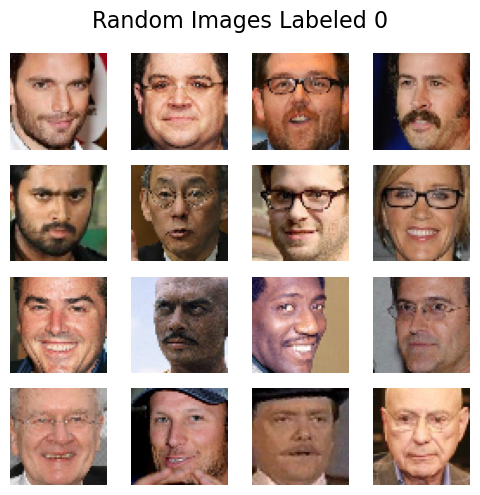

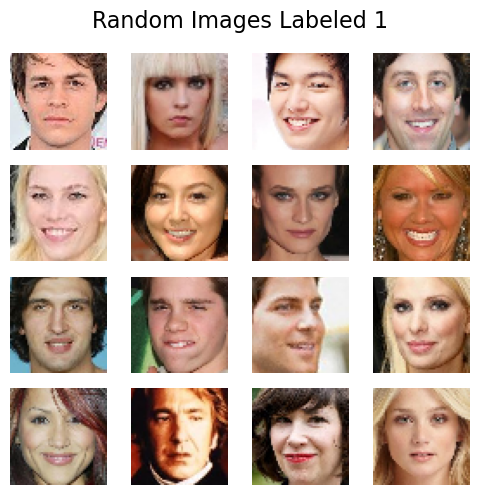

In [5]:
indices_0 = np.where(train_labels == 0)[0]
indices_1 = np.where(train_labels == 1)[0]

num_images = 16
random_indices_0 = np.random.choice(indices_0, num_images, replace=False)
random_indices_1 = np.random.choice(indices_1, num_images, replace=False)

def plot_images(indices, title):
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        img = train_data[indices[i]]
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_images(random_indices_0, 'Random Images Labeled 0')
plot_images(random_indices_1, 'Random Images Labeled 1')

The database appears to consist of facial images. By observing random samples, it can be deduced that class 1 corresponds to uncovered faces, while class 0 represents faces that have facial hair, or that are wearing accessories such as glasses, hats,  and so on.

# Modeling, Preprocessing and Training

In this section we will choose a model to train using the data, while using random weighted sampling to overcome the discrepancy between class sizes, we will put aside 20% of the training data for validation and monitor the model's metrics while training.

A cost-effective approach (considering the size of the dataset) is to train a Convolutional Neural Network (CNN) using transfer learning. This method entails importing a pre-trained model and retraining only the classifier, while keeping the backbone (the main body of the model) frozen and non-trainable. Models like VGG-16 or VGG-19 are effective examples for such applications due to their robust feature extraction capabilities.

In Parkhi et al. (2015)[1], the authors train a VGG-16 architecture for image classification, specifically utilizing the VGG Face dataset. In this project, we import the pre-trained VGGFace model and adapt its classifier to handle two classes. We then further train the model for our specific task. Since the backbone of the model is already trained for feature extraction from facial images, this process is more time-efficient than training a comparable deep network from scratch.

However, in the pre-processing phase, the images must be adapted to suit the requirements of the pre-trained model. This adaptation includes resizing images from their original dimensions (56x56) to the size expected by the model (224x224), and normalizing the images using the mean and standard deviation values that were originally used for training the model, which, in this case, are the same as those used for the ImageNet dataset.

A random weighted sampler is used when training, which samples from both classes with the same probability, however, since many of the images from class 0 will be resued in this case, it is better to include random transformations that augment this class, so that the model could learn differently from the same samples instead of overfitting on the same images, these transformations have to be chosen considering the nature of the images which is of faces, such examples include random horizontal flips and random rotations, jitter and gaussian blur.

The transformations, including augmentations, are applied to the training data, while standard transformations are used for the validation data.

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
re_aug2_norm_transforms = [train_transforms, val_transforms]

The CNN model is initialized and its weights are loaded, with the backbone being set to a frozen state. At the end, a summary is displayed, outlining the various layers of the model and the corresponding number of weights.

In [27]:
from vgg_face_dag import vgg_face_dag

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg_face_dag()
model.load_state_dict(torch.load('vgg_face_dag.pth'))
num_features = model.fc8.in_features
model.fc8 = nn.Linear(in_features=num_features, out_features=2)
model = model.to(device)

for layer in model.children():
    if isinstance(layer, torch.nn.Conv2d):
        for param in layer.parameters():
            param.requires_grad = False
            
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Various parameters, including the number of epochs, batch size, and learning rate, are configured before launching the training process (refer to train function for more details).

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:22<00:00, 30.43Sample(s)/s]


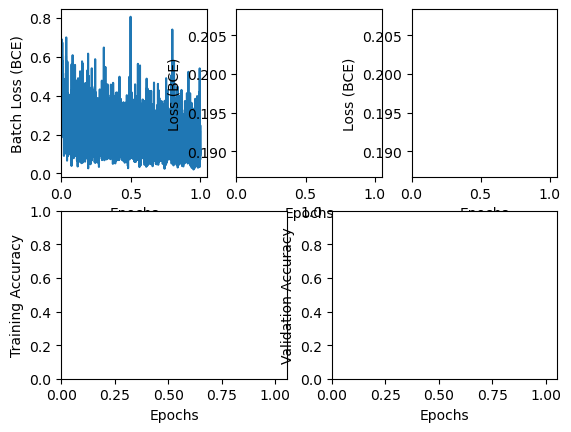

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:20<00:00, 34.80Sample(s)/s]


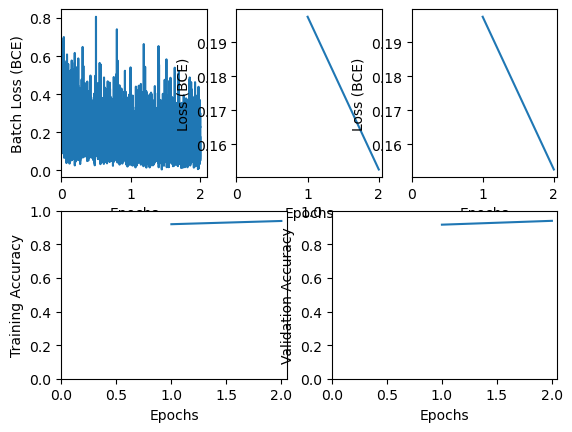

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:23<00:00, 29.31Sample(s)/s]


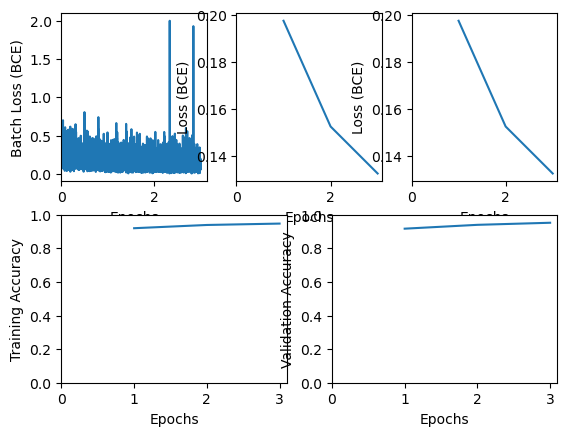

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:20<00:00, 33.30Sample(s)/s]


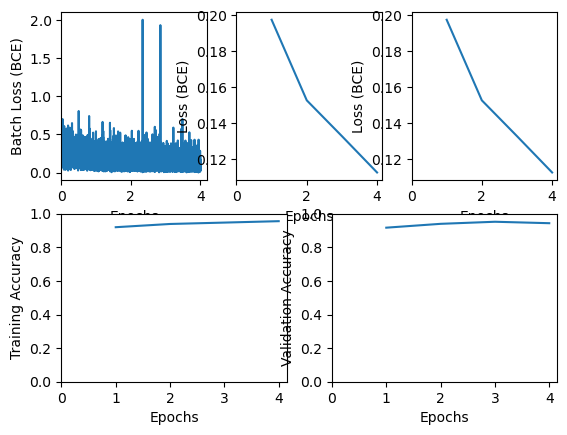

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:20<00:00, 34.28Sample(s)/s]


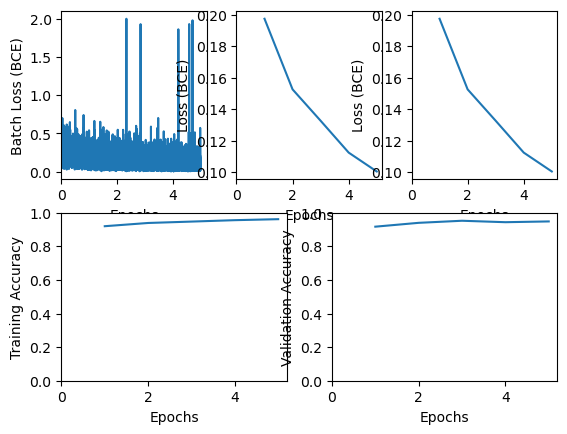

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:20<00:00, 33.78Sample(s)/s]


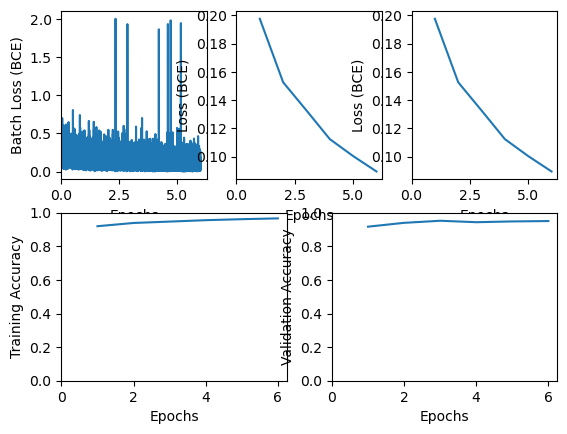

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:19<00:00, 35.05Sample(s)/s]


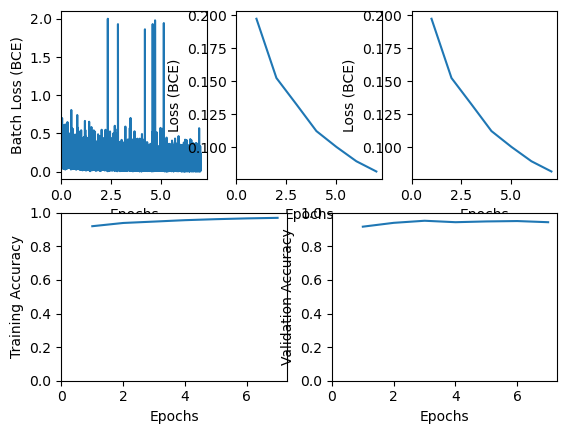

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:18<00:00, 37.18Sample(s)/s]


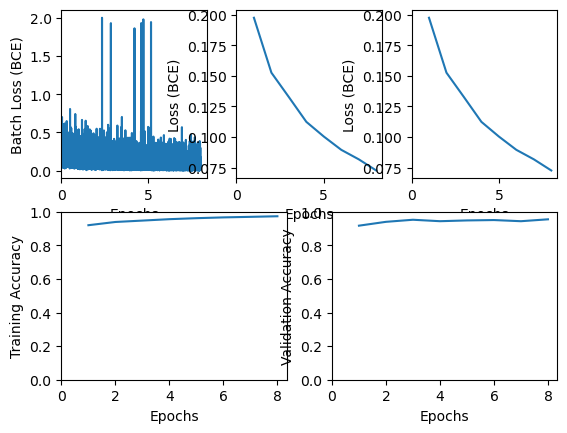

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:19<00:00, 36.23Sample(s)/s]


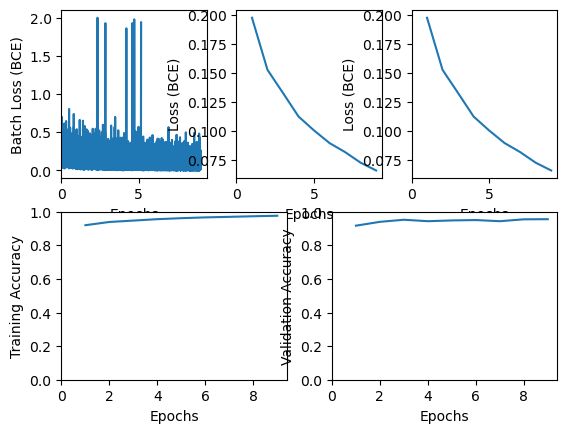

Validation: 100%|██████████████████████████████████████████████████████████████| 697/697 [00:19<00:00, 35.64Sample(s)/s]


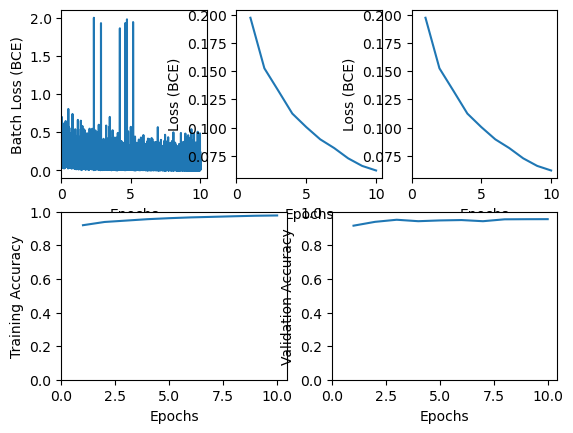

In [28]:
n_epochs = 10
test_percent = 0.2
batch_size = 32
learning_rate = 1e-4

rws = True
train_val_transforms = re_aug2_norm_transforms

train_loss, train_loss_batch, val_loss, train_accuracy, val_accuracy = train(model, train_data, train_labels, test_percent, rws, train_val_transforms, n_epochs, batch_size, learning_rate, device)

In [29]:
print('----------------------------------------------')
print('Final Metrics:')
print('    Training Accuracy: {}%'.format(round(100*train_accuracy[-1], 2)))
print('    Validation Accuracy: {}%'.format(round(100*val_accuracy[-1], 2)))
print('----------------------------------------------')
print('Maximum Metrics:')
print('    Training Accuracy: {}%'.format(round(100*max(train_accuracy), 2)))
print('    Validation Accuracy: {}%'.format(round(100*max(val_accuracy), 2)))
print('----------------------------------------------')

----------------------------------------------
Final Metrics:
    Training Accuracy: 97.77%
    Validation Accuracy: 95.58%
----------------------------------------------
Maximum Metrics:
    Training Accuracy: 97.77%
    Validation Accuracy: 95.58%
----------------------------------------------


In [30]:
torch.save(model.state_dict(), 'face_classification_idemia.pth')

# Prediction

In this section we apply the trained model to unknown images from the test data and save the predictions in a text file for later evaluation using Half Total Error Rate (HTER).

In [31]:
width = 56
height = 56
n_channels = 3
n_images_test = 10130

test_transforms = train_val_transforms[1]

In [32]:
shape_test = (n_images_test, height, width, n_channels)

with open(test_data_dir, 'rb') as file:
    raw_test_data = file.read()

test_data = np.frombuffer(raw_test_data, dtype=np.uint8).reshape(shape_test)

Prediction:   1%|▌                                                           | 100/10130 [00:05<08:28, 19.72Sample(s)/s]

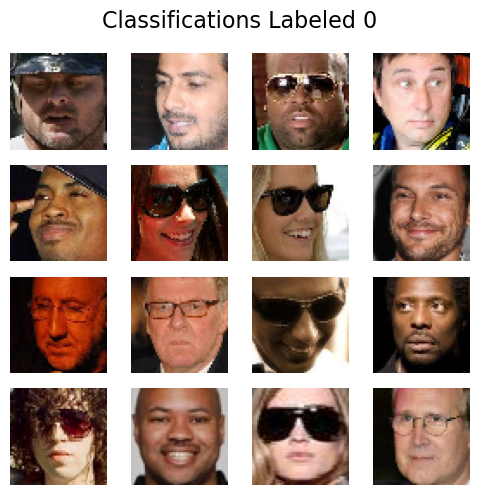

Prediction:   1%|▋                                                           | 117/10130 [00:06<10:16, 16.24Sample(s)/s]

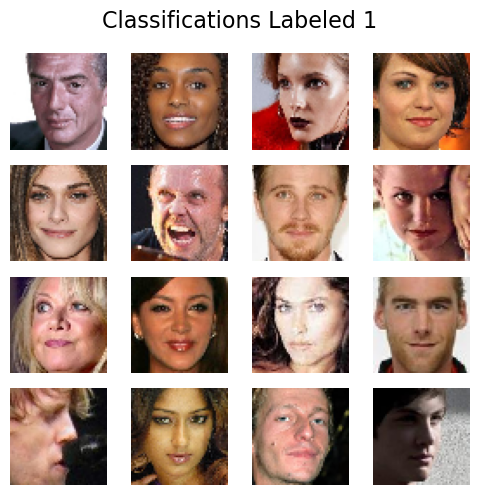

Prediction:  96%|████████████████████████████████████████████████████████▋  | 9734/10130 [08:12<00:19, 19.96Sample(s)/s]

In [ ]:
predict(model, test_data, test_transforms, device)

# Functions/Classes

In this section, the functions and classes used throughout the code are defined. Each function is described individually.

###### Class: ClassificationDataset

* Attributes:
    * data: The numpy data which will used for training or validation subsets.
    * labels: The corresponding numpy classification labels.
    * transforms (Default = None): the transformations which will be applied to the data as preprocessing. 

* Methods:
    * len: Returns dataset length.
    * labels: returns a list containing the classification labels.
    * getitem: Returns an item (image, label) from the dataset while applying the transformations to the image if there are any.

In [9]:
class ClassificationDataset(Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __labels__(self):
        return self.labels
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        sample = Image.fromarray(sample)
        
        if self.transforms:
            sample = self.transforms(sample)

        return sample, label

###### Function: show_metrics

* Inputs:
    * train_loss: The training loss for all epochs.
    * train_loss_batch: The training loss for all batches.
    * train_accuracy: The training classification accuracy for all epochs.
    * val_loss: The validation loss for all epochs.
    * val_accuracy: The validation classification accuracy for all epochs.
    * title (Default = None): The chosen title for the figure.

* Outputs:
    * None

In [10]:
def show_metrics(train_loss, train_loss_batch, val_loss, train_accuracy, val_accuracy, title = None):
    
    plt.figure
    plt.suptitle(title)
    
    plt.subplot(2,3,1)
    aaa = np.linspace(len(train_loss)/len(train_loss_batch), len(train_loss), num = len(train_loss_batch))
    plt.plot(aaa,train_loss_batch)
    plt.xlim(0, None)
    plt.xlabel("Epochs")
    plt.ylabel("Batch Loss (BCE)")
    plt.subplot(2,3,2)
    plt.plot(range(1,len(train_loss)+1),train_loss)
    plt.xlim(0, None)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (BCE)")
    plt.subplot(2,3,3)
    plt.plot(range(1,len(train_loss)+1),train_loss)
    plt.xlim(0, None)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (BCE)")
    
    plt.subplot(2,2,3)
    plt.plot(range(1,len(train_accuracy)+1),train_accuracy)
    plt.xlim(0, None)
    plt.ylim(0, 1)
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.subplot(2,2,4)
    plt.plot(range(1,len(val_accuracy)+1),val_accuracy)
    plt.xlim(0, None)
    plt.ylim(0, 1)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
        
    plt.show()

###### Function: create_sampler

Creates a random weighted sampler that the dataloader uses during the training process to sample from the training set in a randomized manner. This method ensures that each class is represented equally, providing an equal probability of selection for training the model, thereby addressing class imbalance issues.

* Inputs:
    * dataset: the training dataset from which the dataloader will be sampling.
    * class_counts: a list representing the number of instances in every class..
    * device: The chosen device.

* Outputs:
    * sampler: the WeightedRandomSampler object.

In [11]:
def create_sampler(dataset, class_counts):
    num_samples = int(sum(class_counts))
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    #weights = [class_weights[label] for _,label in dataset]
    weights = [class_weights[label] for label in dataset.__labels__().tolist()]
    
    sampler = WeightedRandomSampler(weights, num_samples, replacement=True)
    return sampler

###### Function: train

The training utilizes Binary Cross-Entropy as the loss function and Adam as the optimizer. Initially, the data and labels are divided into training and validation subsets. During the training phase, a random weighted sampler is employed to ensure randomized sampling from the training dataset. This is coupled with the application of augmentation, resizing, and normalization transforms. Subsequently, the model parameters are updated, and essential metrics, such as loss and accuracy, are tracked. For evaluation, the model is tested on the validation set, which also undergoes resizing and normalization. The process culminates in the output of these recorded metrics, providing a detailed account of loss and accuracy for both the training and validation subsets.

* Inputs:
    * model: The Deep Learning model.
    * data: The numpy data which will be divided into training and validation subsets.
    * labels: The corresponding numpy classification labels.
    * test_percent: Percentage of original data put aside for validation.
    * rws (Boolean): Whether to use a random weighted sampler.
    * transforms: A tuple/list of size 2 containing the transformations which will be applied to the training and validation data as preprocessing. 
    * n_epochs: The number of epochs for the training process.
    * batch_size: The batch size (or how many images are passed by the model for training per iteration).
    * learning_rate: The chosen learning rate.
    * device: The chosen device.

* Outputs:
    * train_loss: The training loss for all epochs.
    * train_loss_batch: The training loss for all batches.
    * train_accuracy: The training classification accuracy for all epochs.
    * val_loss: The validation loss for all epochs.
    * val_accuracy: The validation classification accuracy for all epochs.

In [22]:
def train(model, data, labels, test_percent, rws, transforms, n_epochs, batch_size, learning_rate, device):
            
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCELoss()
    
    train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size = test_percent, 
                                                                      random_state=42, stratify=labels)    
    train_dataset = ClassificationDataset(train_data, train_labels, transforms[0])
    val_dataset = ClassificationDataset(val_data, val_labels, transforms[1])
    
    if rws:
        class_counts = [sum(train_labels == 0), sum(train_labels == 1)]
        sampler = create_sampler(train_dataset, class_counts)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = sampler, num_workers = 8)
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)
    
    n_batch_train = len(train_loader)
    n_train = n_batch_train*batch_size
    
    train_loss = []
    train_loss_batch = []
    train_accuracy = []
    
    val_loss = []
    val_accuracy = []
    
    for epoch in range(1,n_epochs+1):
        
        model.train()
        
        epoch_train_loss = 0        
        epoch_train_accuracy = 0
        
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{n_epochs}', unit='Sample(s)') as pbar:                
            for batch in train_loader:
                
                inputs, labels = batch
                inputs=inputs.type(torch.float32).to(device)
                labels=labels.type(torch.long).to(device)             
                
                optimizer.zero_grad()

                outputs = model(inputs)
                sig_outputs = torch.sigmoid(outputs)
                                
                labels = F.one_hot(labels, num_classes=2)
                predictions = torch.argmax(sig_outputs, 1)
                predictions = F.one_hot(predictions, num_classes=2)
                
                loss = criterion(sig_outputs, labels.float())
                
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                train_loss_batch.append(loss.item())
                
                epoch_train_accuracy += accuracy_score(labels.detach().cpu(), predictions.detach().cpu())
                
                pbar.update(batch_size)
                
        train_loss.append(epoch_train_loss/n_batch_train)
        train_accuracy.append(epoch_train_accuracy/n_batch_train)
        
        epoch_val_loss, epoch_val_accuracy = evaluate(model, val_loader, device)
        
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        
        show_metrics(train_loss, train_loss_batch, val_loss, train_accuracy, val_accuracy)
    
    return train_loss, train_loss_batch, val_loss, train_accuracy, val_accuracy

In [1]:
def train_kfold(model, data, labels, kfold, rws, transform, n_epochs, batch_size, learning_rate, device):
        
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCELoss()
    
    train_loss = []
    train_loss_batch = []
    train_accuracy = [0 for _ in range(n_epochs)]
    
    val_loss = []
    val_accuracy = [0 for _ in range(n_epochs)]
    
    for fold, (train_index, val_index) in enumerate(kfold.split(data, labels)):
                
        fold_train_data = data[train_index]
        fold_val_data = data[val_index]
        fold_train_labels = labels[train_index]
        fold_val_labels = labels[val_index]
            
        train_dataset = ClassificationDataset(fold_train_data, fold_train_labels, transforms[0])
        val_dataset = ClassificationDataset(fold_val_data, fold_val_labels, transforms[1])
        
        if rws:
            class_counts = [sum(train_labels[train_index] == 0), sum(train_labels[train_index] == 1)]
            sampler = create_sampler(train_dataset, class_counts)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = sampler)
        else:
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
        
        n_batch_train = len(train_loader)
        n_train = n_batch_train*batch_size
    
        fold_train_loss = []
        fold_train_loss_batch = []
        fold_train_accuracy = []
        
        fold_val_loss = []       
        fold_val_accuracy = []
        
        for epoch in range(1,n_epochs+1):

            model.train()

            epoch_train_loss = 0        
            epoch_train_accuracy = 0
            epoch_train_f1 = 0
            correct = 0

            with tqdm(total=n_train, desc=f'Fold {fold+1}/{kfold.get_n_splits()}, Epoch {epoch}/{n_epochs}', 
                      unit='Sample(s)') as pbar:                
                for batch in train_loader:

                    inputs, labels = batch
                    inputs=inputs.type(torch.float32).to(device = device)
                    labels=labels.type(torch.long).to(device = device)                

                    optimizer.zero_grad()

                    outputs = model(inputs)
                    sig_outputs = torch.sigmoid(outputs)
                    labels = F.one_hot(labels, num_classes=2)
                    predictions = torch.argmax(sig_outputs, 1)
                    predictions = F.one_hot(predictions, num_classes=2)

                    loss = criterion(sig_outputs, labels.float())

                    loss.backward()
                    optimizer.step()

                    epoch_train_loss += loss.item()
                    fold_train_loss_batch.append(loss.item())
                    epoch_train_accuracy += accuracy_score(labels.detach().cpu(), predictions.detach().cpu())

                    pbar.update(batch_size)

            fold_train_loss.append(epoch_train_loss/n_batch_train)
            fold_train_accuracy.append(epoch_train_accuracy/n_batch_train)

            epoch_val_loss, epoch_val_accuracy = evaluate(model, val_loader, device)
            
            fold_val_loss.append(epoch_val_loss)
            fold_val_accuracy.append(epoch_val_accuracy)
            
        show_metrics(fold_train_loss, fold_train_loss_batch, fold_val_loss, fold_train_accuracy, fold_val_accuracy, f"Fold {fold+1}")
            
        train_loss.extend(fold_train_loss)
        train_loss_batch.extend(fold_train_loss_batch)
        train_accuracy = [accuracy + fold_accuracy/kfold.get_n_splits() for accuracy, fold_accuracy in zip(train_accuracy, fold_train_accuracy)]
        
        val_loss.extend(fold_val_loss)
        val_accuracy = [accuracy + fold_accuracy/kfold.get_n_splits() for accuracy, fold_accuracy in zip(val_accuracy, fold_val_accuracy)]
        
    show_metrics(train_loss, train_loss_batch, val_loss, train_accuracy, val_accuracy, "Total")
        
    return train_loss, train_loss_batch, val_loss, train_accuracy, val_accuracy

###### Function: evaluate

The model is evaluated using a loop similar to the one in the training function, but with a crucial difference: gradients are not computed during this phase. This adjustment significantly reduces the time required for evaluation compared to training.

* Inputs:
    * model: The Deep Learning model.
    * dataloader: The validation dataloader.
    * device: The chosen device.

* Outputs:
    * epoch_val_loss: The calculated loss for the given epoch.
    * epoch_val_accuracy: The calculated classification accuracy for the given epoch.

In [14]:
def evaluate(model, dataloader, device): 
    
    model.eval()
        
    n_val = len(dataloader)
    
    criterion = torch.nn.BCELoss()
    
    epoch_val_loss = 0
    epoch_val_accuracy = 0
    
    with tqdm(total=n_val, desc=f'Validation', unit='Sample(s)') as pbar:
        for batch in dataloader:

            inputs, labels = batch
            inputs=inputs.type(torch.float32).to(device = device)
            labels=labels.type(torch.long).to(device = device)
            
            with torch.no_grad():
                
                outputs = model(inputs)
                sig_outputs = torch.sigmoid(outputs)
                
                labels = F.one_hot(labels, num_classes=2)
                predictions = torch.argmax(outputs, 1)
                predictions = F.one_hot(predictions, num_classes=2)
                                
                loss = criterion(sig_outputs, labels.float())
                
                epoch_val_loss += loss.item()
                epoch_val_accuracy += accuracy_score(labels.detach().cpu(), predictions.detach().cpu())
                
            pbar.update(1)
            
    model.train()
    
    epoch_val_loss = epoch_val_loss/n_val
    epoch_val_accuracy = epoch_val_accuracy/n_val
    
    return epoch_val_loss, epoch_val_accuracy

###### Function: predict

The model is employed to predict and classify unknown images. The classifications are then saved in a file named 'predictions.txt' for subsequent evaluation. Additionally, the initial few predictions for each class are displayed for a quick overview.

* Inputs:
    * model: The Deep Learning model.
    * data: The numpy data which will be used for evaluating the model.
    * device: The chosen device.

* Outputs:
    * None

In [15]:
def predict(model, data, test_transforms, device):
    num_images = 16
    j = 0
    k = 0
    pred_dir = os.path.join(data_dir, 'predictions.txt')
    
    if os.path.exists(pred_dir):
        os.remove(pred_dir)
    
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    fig.suptitle('Classifications Labeled 0', fontsize=16)
        
    with open(pred_dir, 'w') as file:
        with tqdm(total=data.shape[0], desc='Prediction', unit='Sample(s)') as pbar:
            for i in range(data.shape[0]):

                image = Image.fromarray(data[i])
                image = test_transforms(image).to(device)
                image = torch.unsqueeze(image, 0)

                output = model(image)
                sig_output = torch.sigmoid(output)
                pred = torch.argmax(sig_output, 1)
                
                
                if j == num_images:
                    plt.tight_layout()
                    plt.show()
                    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
                    fig.suptitle('Classifications Labeled 1', fontsize=16)
                    j += 1
                
                if pred.item() == 0 and j < num_images:
                    ax = axes.flatten()[j]
                    img = data[i]
                    ax.imshow(img)
                    ax.axis('off')
                    j += 1
                elif pred.item() == 1 and k < num_images and j > num_images:
                    ax = axes.flatten()[k]
                    img = data[i]
                    ax.imshow(img)
                    ax.axis('off')
                    k += 1
                
                if k == num_images:
                    plt.tight_layout()
                    plt.show()
                    k += 1
                    
                file.write(str(pred.item()) + '\n')

                pbar.update(1)

    print('Prediction finished ! predictions.txt file created.')

# References

1. Parkhi, Omkar, Andrea Vedaldi, and Andrew Zisserman. "Deep face recognition." BMVC 2015-Proceedings of the British Machine Vision Conference 2015. British Machine Vision Association, 2015.